## Prediction Model test

So, this is a small notebook (Jupyter) to test the prediction model used by Kansal et al. with the data obtained from the testbed in Spain.

I like to use pandas (https://pandas.pydata.org/) since it is incredible powerfull for data analysis. So let's start to import our data:

In [2]:
import pandas as pd
pd.set_option('max_columns', 50)
pd.set_option('display.width', 1000)
import matplotlib.pyplot as plt
%matplotlib inline

Ok, so now import the data in a Dataframe, and parse the first two column as date and time correctly

In [3]:
def dateparse(d,t):
    dt = d + " " + t
    return pd.datetime.strptime(dt,'%d/%m/%y %H:%M:%S')

cols = ['Date', 'Time', 'Load', 'Battery', 'Panel','Wind', 'Temp', 'Humidity', 'Volt']
data = pd.read_csv('test.csv',delimiter=';',header=0,names=cols,decimal=',',parse_dates=[[0,1]],date_parser=dateparse)
data.set_index('Date_Time',inplace=True)

Perfect, now we have all the data in date, let's show some of them:

In [4]:
data.head()

,Load,Battery,Panel,Wind,Temp,Humidity,Volt
Date_Time,,,,,,,
2018-07-31 13:07:15,13.3,326.3,353.1,0.98,33.93,21.92,3.89
2018-07-31 13:08:15,14.0,314.4,342.5,0.59,33.88,21.84,3.88
2018-07-31 13:09:16,13.4,309.6,335.5,0.39,33.84,22.14,3.88
2018-07-31 13:10:16,13.8,285.1,313.8,2.55,33.71,23.18,3.88
2018-07-31 13:11:16,13.6,292.9,314.7,2.03,33.62,23.25,3.88


In [5]:
data.describe()

,Load,Battery,Panel,Wind,Temp,Humidity,Volt
count,93438.000000,93438.000000,93438.000000,93438.000000,93438.000000,93438.000000,93438.000000
mean,13.707405,0.735243,86.503448,1.582866,26.630948,41.207224,4.189683
std,0.343658,26.452690,124.974071,1.053495,7.285831,20.064406,0.037817
min,8.500000,-23.600000,-0.800000,-1.050000,9.410000,9.870000,3.830000
25%,13.400000,-14.000000,-0.300000,0.850000,20.760000,24.790000,4.170000
50%,13.700000,-13.500000,8.300000,1.370000,25.700000,37.590000,4.200000
75%,14.000000,0.100000,149.675000,2.160000,32.420000,55.690000,4.210000
max,23.200000,326.300000,436.600000,11.430000,45.830000,139.320000,4.230000


ok, let's plot some values:

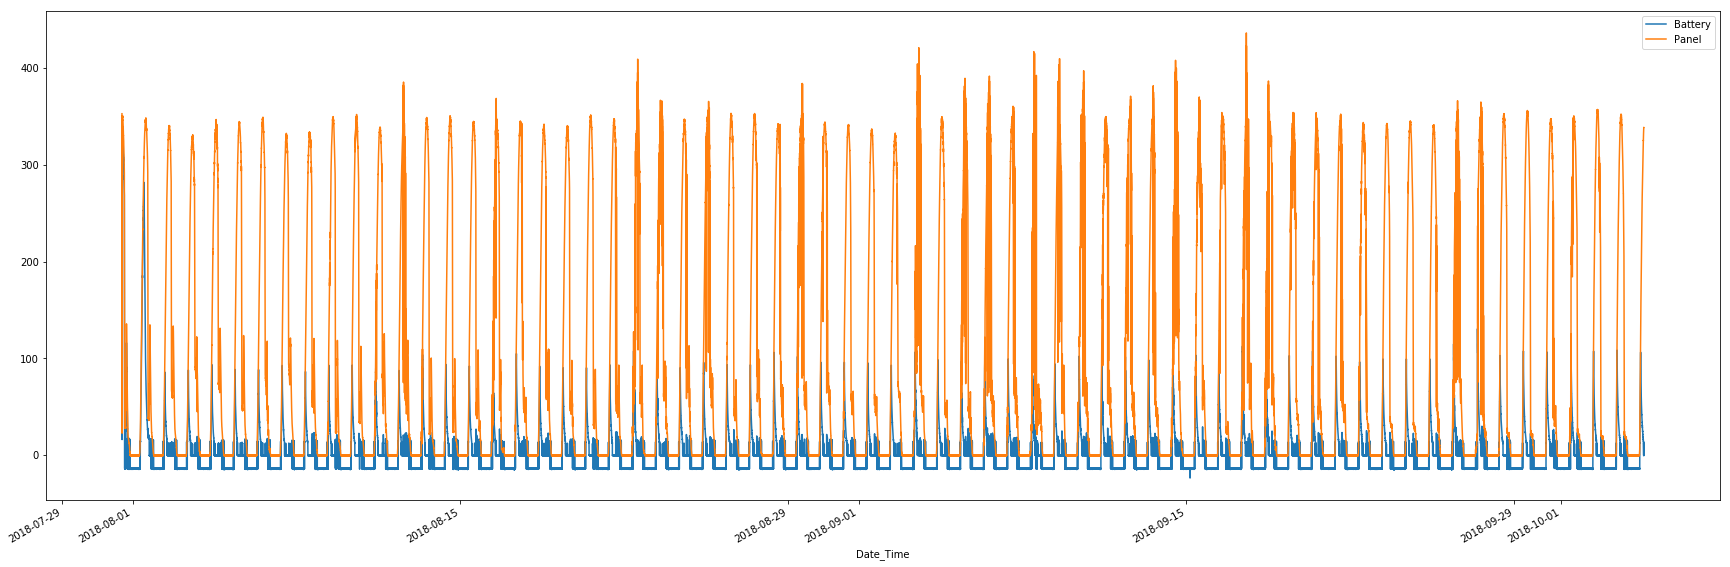

In [13]:
plt.rcParams["figure.figsize"] = [30,10]
out = data.plot(y=['Battery','Panel'])

ok, but too much data, we use the week from 2/9/2018 to 9/9/2018 since it seems also to contain more variable output from the panel.

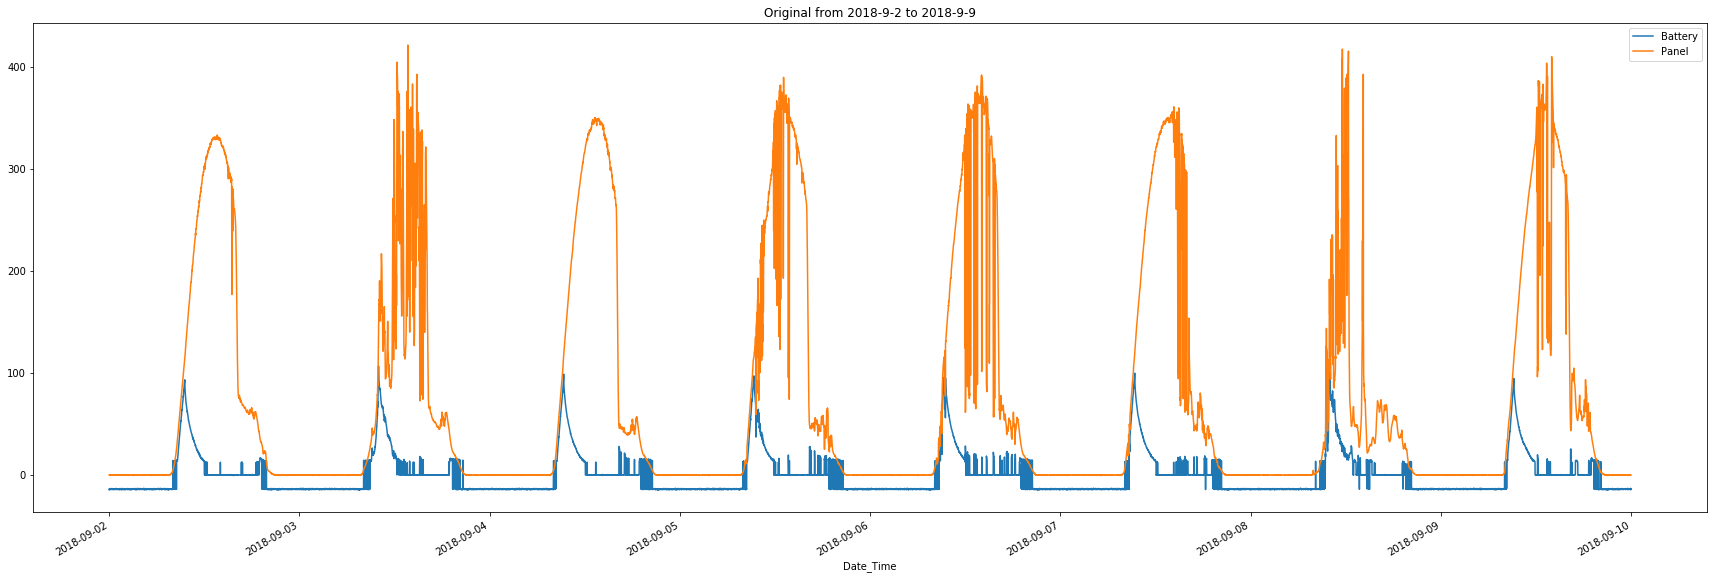

In [14]:
start,end = '2018-9-2','2018-9-9'
t = "from {} to {}".format(start,end) #usefull for the titles.
out = data[start:end].plot(y=['Battery','Panel'],title="Original "+t)

ok, much better, similar to Kansal we want to aggregate the data in bins to smooth out small variation in the output and use less memory to store the data used in the model. In the paper of Kansal a single day is divided into 48 slots of 30 minutes. We need to aggregate our data, but Pandas can do this for us in a single step.

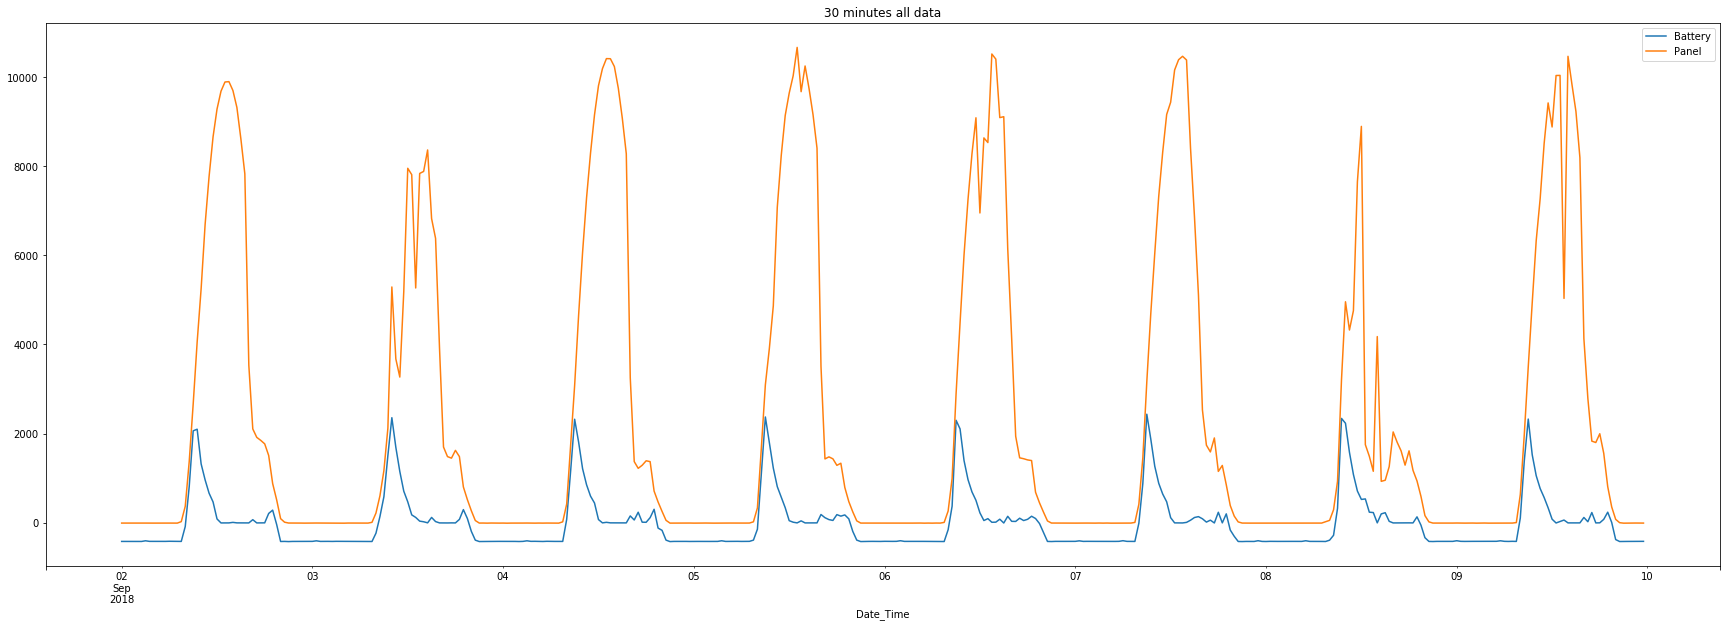

In [20]:
r = data.resample('30min').sum()   # yes, so simple.
out = r[start:end].plot(y=['Battery','Panel'],title="30 minutes resampled")

In Kansal the prediction model use an exponential moving average of the data, so for each bucket, given $\alpha=0.5$ we have:
$$ pred(0) = x(0) $$
$$ pred(i) = \alpha*pred(i-1)+(1-\alpha)*x(i) $$
but Pandas is again able to do this with a single function:

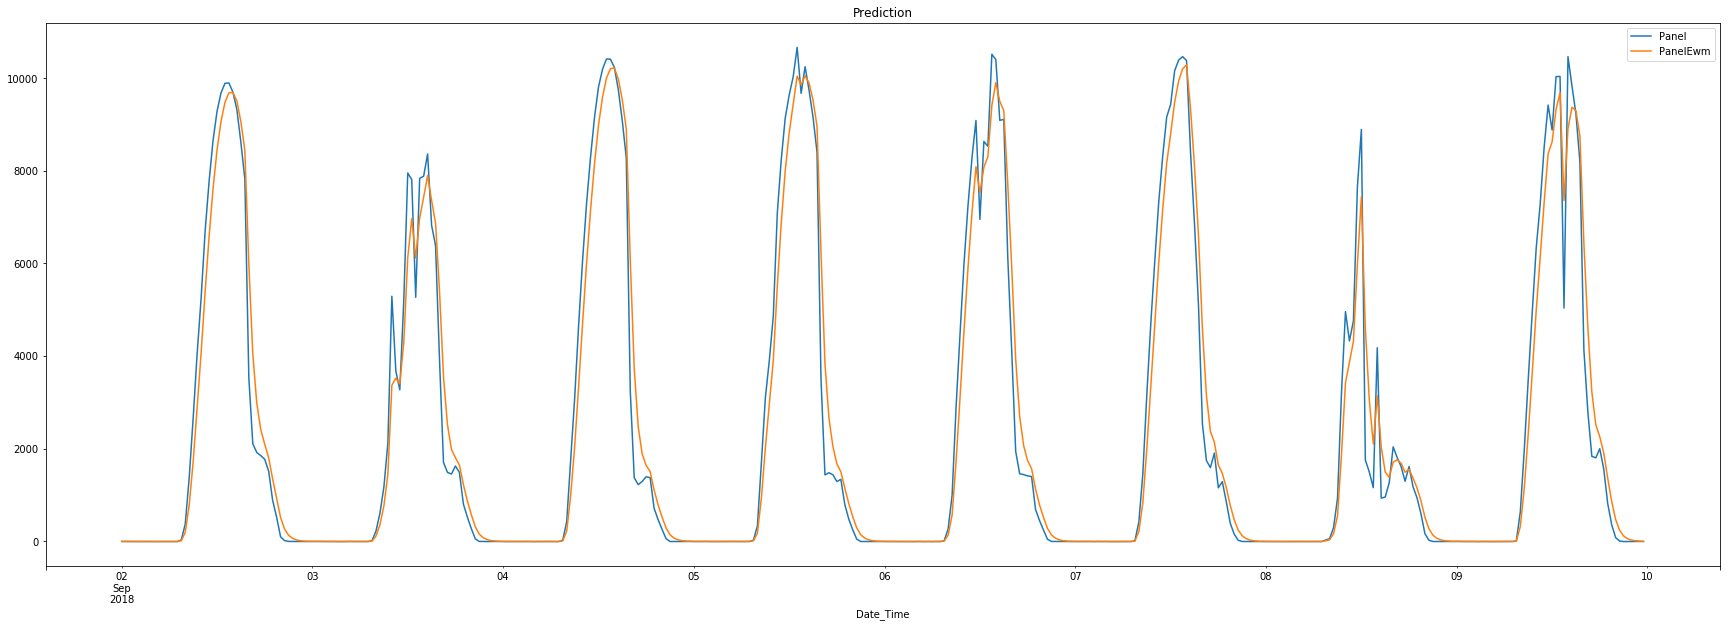

In [22]:
r['PanelEwm'] = r.Panel.ewm(alpha=0.5,adjust=False).mean()
out = r[start:end].plot(y=['Panel','PanelEwm'],title="Prediction")

So, the prediction is quite good. At least in the plot seems good, we note that it tends to underestimate the production while it rise and to overestimate it while it decrease, since it incapsulate a memory that imply a certain level of delay to adapt to the real values. In the next days, I'll take a look for different values of $\alpha$, just to be sure that Kansal selected the best parameter. I'd also want to check if this is affected by the interval size (30min). Ok. Now let's see what we have used until now, as prediction for the old papers, i.e. the old code.

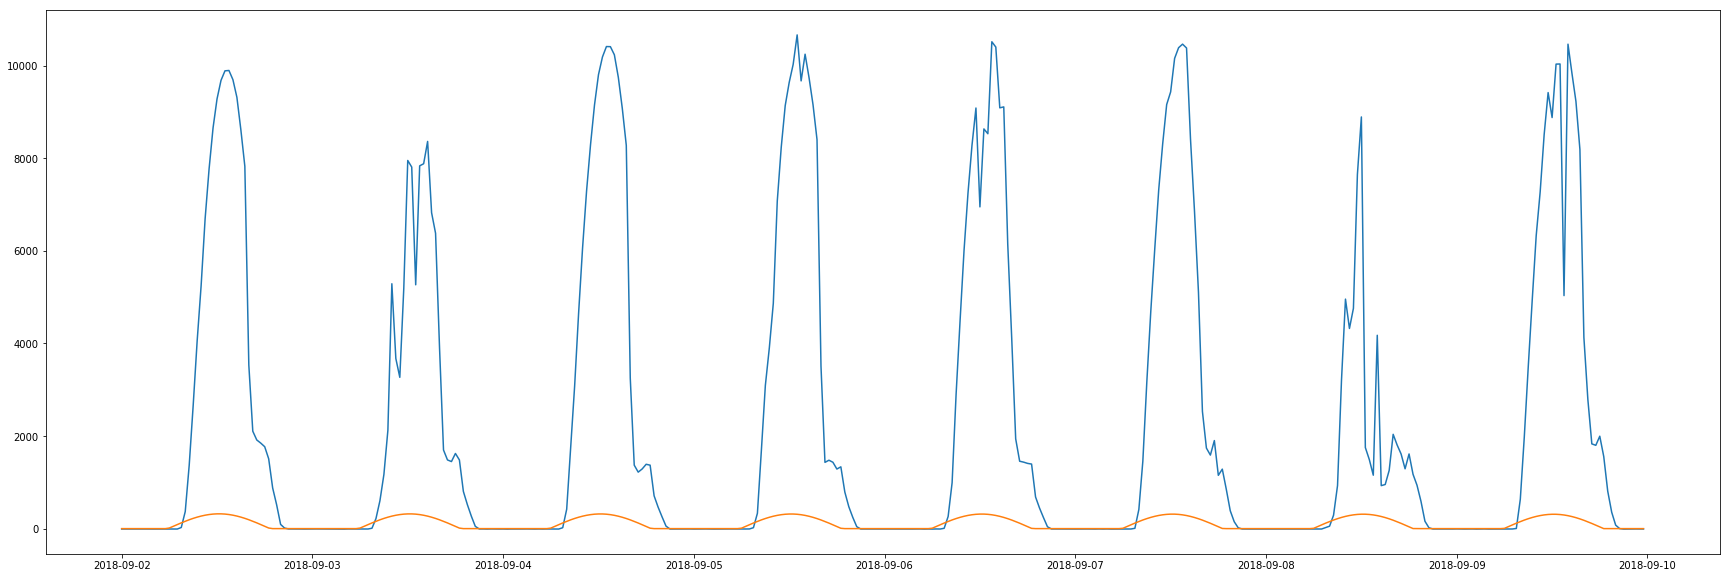

In [27]:
from solar import amph,Minutes,Hours
import numpy as np
Nslots = len(r[start])
# prediction for days from start to end
offset = 0
solarpred = np.zeros(8*Nslots)
for i in range(2,10):
	solarpred[offset:offset+Nslots] = amph(i,9,(Minutes*Hours)/Nslots)
	offset += Nslots
ascissa = r[start:end].index.values
out = plt.plot(ascissa,r[start:end].Panel.values,ascissa,solarpred)

Ok, as we see in the plot above, our values are maybe in a different scale. Moreover if you look carefully, we see that the peek of the production in the prediction (orange line) is anticipated with respect to the real values. I decided to rescale it to compare properly, but I don't know why the scale factor is just $31$.

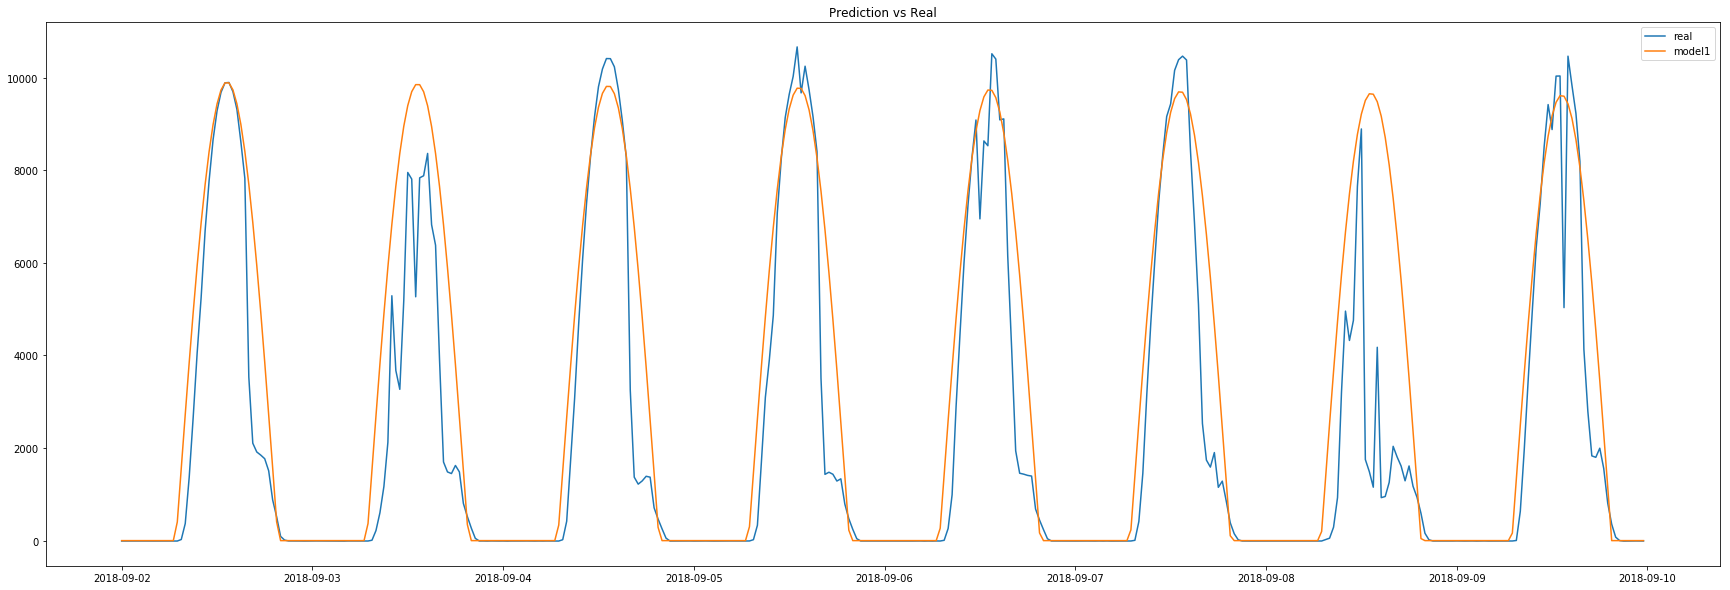

In [34]:
rolled = np.roll(solarpred,2)*31

plt.title("Prediction vs Real"),
out = plt.plot(ascissa,r[start:end].Panel.values,label='real')
out = plt.plot(ascissa,rolled,label="model1")
out = plt.legend(loc='upper right')

and finally we compare all three model. I plot only the last three days, so it is simple to see the results.

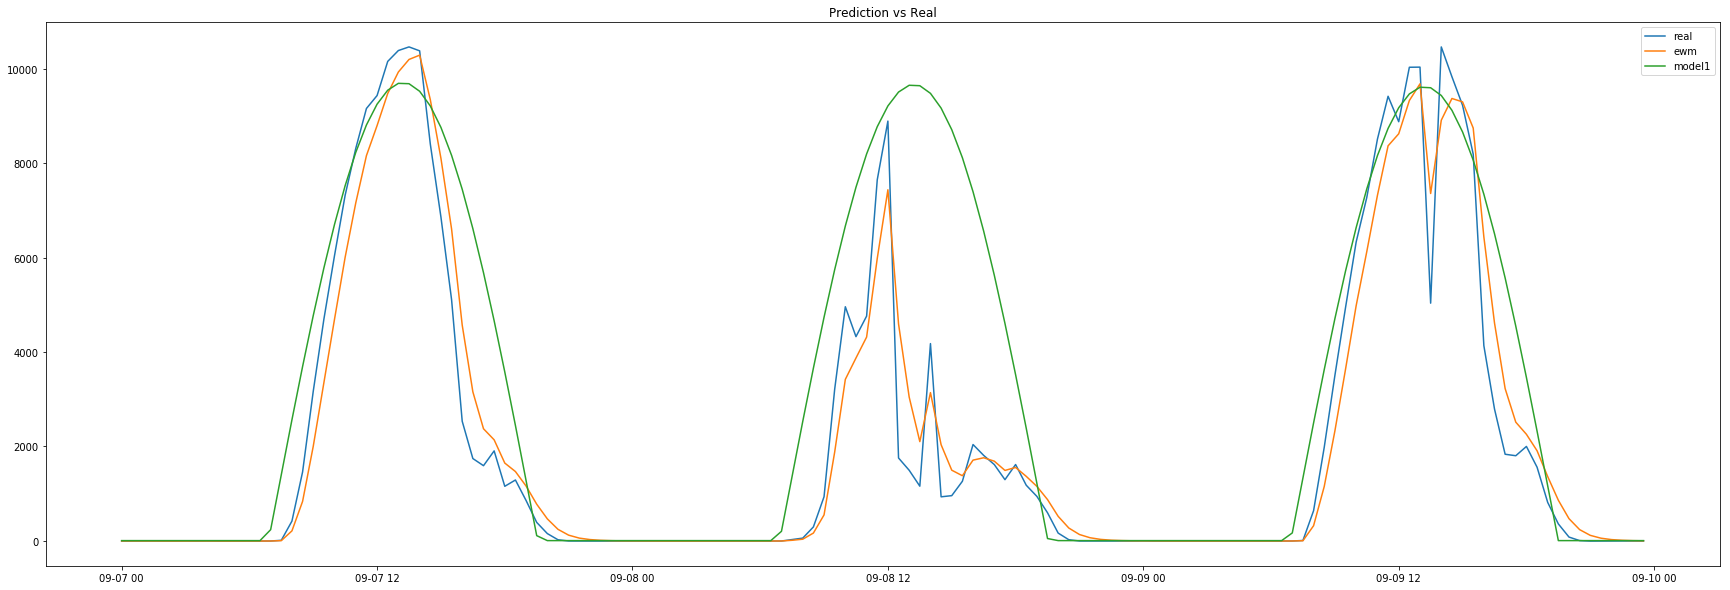

In [39]:
plt.figure()
plt.title("Prediction vs Real"),
start = '2018-09-07'
ascissa = r[start:end].index.values
out = plt.plot(ascissa,r[start:end].Panel.values,label='real')
out = plt.plot(ascissa,r[start:end].PanelEwm.values,label='ewm')
out = plt.plot(ascissa,rolled[48*5:],label="model1")
out = plt.legend(loc='upper right')

Ok, it is clear that our old model in the python code was very bad compared to real data, since it do not take into account clouds and so on. Just the average for month. 

For the next step, please Xavier if you have more data, put them in the shared folder on google drive (the ones shared by Soledad), I do not know what is the status of the work for the IDIN paper. Anyway, if you need help, just ask.